In [1]:
import pandas as pd
import graphviz

In [2]:
alternatives = pd.read_csv("./data/milosz_alternatives1.csv")
criteria = pd.read_csv("./data/milosz_criteria1.csv")

In [3]:
alternatives

,country,power,safety,construction_cost
0,ITA,98,8,400
1,BEL,58,0,800
2,GER,66,5,1000
3,SWE,74,3,600
4,AUT,80,7,200
5,FRA,82,10,600


In [4]:
criteria

,criterion_name,criterion_type,indifference,preference,veto,weight
0,power,gain,0,0.000001,NaN,3
1,safety,gain,0,2.000000,NaN,2
2,construction_cost,cost,100,300.000000,NaN,5


In [5]:
from validate_input import validate_input
validate_input(alternatives, criteria)

True

In [6]:
print(criteria.iloc[0])

criterion_name       power
criterion_type        gain
indifference             0
preference        0.000001
veto                   NaN
weight                   3
Name: 0, dtype: object


In [7]:
# compute preference between alternatives a and b
def marginal_preference_index(a: pd.Series, b: pd.Series, criterion: pd.Series) -> float:
    p = criterion["preference"]
    q = criterion["indifference"]
    criterion_type = criterion["criterion_type"]
    criterion_name = criterion["criterion_name"]
    a_val = a[criterion_name]
    b_val = b[criterion_name]
    difference = a_val - b_val
    if criterion_type == "cost":
        difference *= -1

    if difference > p:
        return 1
    if difference <= q:
        return 0
    return (difference - q) / (p-q)

In [8]:
def comprehensive_preference_index(a: pd.Series, b: pd.Series, criteria: pd.DataFrame) -> float:
    numerator_sum = sum([marginal_preference_index(a, b, criterion[1])*criterion[1]["weight"] for criterion in criteria.iterrows()])
    sum_of_weights = sum([criterion[1]["weight"] for criterion in criteria.iterrows()])
    return numerator_sum/sum_of_weights

In [9]:
# TODO delete this cell after its outputs are discussed by the developers
# different results for FRA-AUT and AUT-FRA than in the presentation
# manual verification suggests that Milosz made an oopsie
for alternative in alternatives.iterrows():
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue

        print(alternative[1][0], b_alternative[1][0], comprehensive_preference_index(alternative[1], b_alternative[1], criteria))

ITA BEL 1.0
ITA GER 1.0
ITA SWE 0.75
ITA AUT 0.4
ITA FRA 0.55
BEL ITA 0.0
BEL GER 0.25
BEL SWE 0.0
BEL AUT 0.0
BEL FRA 0.0
GER ITA 0.0
GER BEL 0.5
GER SWE 0.2
GER AUT 0.0
GER FRA 0.0
SWE ITA 0.0
SWE BEL 0.75
SWE GER 0.8
SWE AUT 0.0
SWE FRA 0.0
AUT ITA 0.25
AUT BEL 1.0
AUT GER 1.0
AUT SWE 1.0
AUT FRA 0.5
FRA ITA 0.2
FRA BEL 0.75
FRA GER 1.0
FRA SWE 0.5
FRA AUT 0.5


In [10]:
def positive_flow(alternative: pd.Series, alternatives: pd.DataFrame, criteria: pd.DataFrame) -> float:
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(alternative[1], b_alternative[1], criteria)
    return flow

def negative_flow(alternative, alternatives, criteria):
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(b_alternative[1], alternative[1], criteria)
    return flow

In [11]:
# again, the results for AUT and FRA are different than in the lecture
# they are however consistent with the results obtained earlier on in the notebook
for alternative in alternatives.iterrows():
    print(alternative[1][0],
          positive_flow(alternative, alternatives, criteria),
          negative_flow(alternative, alternatives, criteria))

ITA 3.7 0.45
BEL 0.25 4.0
GER 0.7 4.05
SWE 1.55 2.45
AUT 3.75 0.9
FRA 2.95 1.05


In [12]:
g = graphviz.Digraph(comment="Test")
g.node("A", "A")
g.node("B", "B")
g.node("C", "C")
g.edges(["AB", "AC", "BC"])
print(g.source)

// Test
digraph {
	A [label=A]
	B [label=B]
	C [label=C]
	A -> B
	A -> C
	B -> C
}



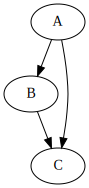

In [13]:
g

In [81]:
def incomplete_ranking_to_graph(ranking: list, relations_dict: dict):
    # to differentiate between incomparability and indifference
    def group_alternatives_in_ranking(ranking: list, relations_dict: dict):
        grouped_ranking = []
        for level in ranking:
            # all alternatives on the same level are either PAIRWISE indifferent or incomparable
            # alternatives within a level are divided into groups of indifferent alternatives
            # the alternatives in different groups are incomparable to each other
            if len(level) == 1:
                grouped_ranking.append([level])
                continue
            ungrouped_alternatives = level[1:]
            current_group = [level[0]]
            grouped_alternatives = []
            while ungrouped_alternatives:
                alternatives_to_group = []
                for alternative in ungrouped_alternatives:
                    if current_group[0] == alternative:
                        continue
                    if relations_dict[(current_group[0], alternative)] == "I":
                        current_group.append(alternative)
                        alternatives_to_group.append(alternative)
                grouped_alternatives.append(current_group)
                for alternative in alternatives_to_group:
                    ungrouped_alternatives.remove(alternative)
                current_group = []
                if ungrouped_alternatives:
                    current_group = [ungrouped_alternatives[0]]
                    ungrouped_alternatives.remove(ungrouped_alternatives[0])
            if current_group:
                grouped_alternatives.append(current_group)
            grouped_ranking.append(grouped_alternatives)
        return grouped_ranking
    grouped_ranking = group_alternatives_in_ranking(ranking, relations_dict)
    ranking_graph = graphviz.Digraph(comment="Ranking of alternatives")
    # add the top level to the graph
    print(grouped_ranking)
    for group in grouped_ranking[0]:
        node_label = ' '.join(group)
        ranking_graph.node(node_label, node_label)
    previous_level = grouped_ranking[0]
    # for lower levels, add connection from upper groups to these
    for level in grouped_ranking[1:]:
        for group in level:
            pass
        
    return ranking_graph

[[['a1']], [['a6'], ['a8']], [['a5'], ['a7']], [['a2']], [['a4']], [['a3']]]


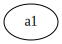

In [83]:
test_ranking = [["a1"], ["a6", "a8"], ["a5", "a7"], ["a2"], ["a4"], ["a3"]]
test_dict = dict([
    (("a1", "a2"), "P"), (("a1", "a3"), "P"), (("a1", "a4"), "P"), (("a1", "a5"), "P"), (("a1", "a6"), "P"), (("a1", "a7"), "P"), (("a1", "a8"), "P"), 
    (("a2", "a3"), "P"), (("a2", "a4"), "P"), (("a2", "a7"), "?"),
    # a3 is not preferred to anything
    (("a4", "a3"), "P"), (("a4", "a7"), "?"),
    (("a5", "a2"), "P"), (("a5", "a3"), "P"), (("a5", "a4"), "P"), (("a5", "a7"), "?"),
    (("a6", "a2"), "P"), (("a6", "a3"), "P"), (("a6", "a4"), "P"), (("a6", "a5"), "P"), (("a6", "a7"), "P"), (("a6", "a8"), "?"),
    (("a7", "a3"), "P"),
    (("a8", "a2"), "P"), (("a8", "a3"), "P"), (("a8", "a4"), "P"), (("a8", "a5"), "P"), (("a8", "a6"), "?"), (("a8", "a7"), "P"),
    ])
incomplete_ranking_to_graph(test_ranking, test_dict)

In [79]:
# TODO: implement
# still work in progress
def PROMETHEE1_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame):
    # determining relations between all pairs of alternatives based on positive and negative flows
    positive_flow_dict = dict((a[1][0], positive_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    negative_flow_dict = dict((a[1][0], negative_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    alternative_names = alternatives.iloc[:, 0].tolist()
    relations_dict = dict()
    for name in alternative_names:
        for different_name in alternative_names:
            if name == different_name:
                continue
            if ((positive_flow_dict[name] >= positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name]) or
               (positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] <= negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = 'P'
            elif (positive_flow_dict[name] == positive_flow_dict[different_name] and
                  negative_flow_dict[name] == negative_flow_dict[different_name]):
                relations_dict[((name, different_name))] = 'I'
            elif ((positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] > negative_flow_dict[different_name]) or
               (positive_flow_dict[name] < positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = '?'

    # key: alternative; value: list of all alternatives preferred to it
    # the outranking alternatives are removed step-by-step as the ranking is built from top to bottom
    # e. g. a dictionary: {a: [], b: [a], c: [a, b]} represents the ranking: a>b>c
    # after the first iteration of the while loop it is updated to {a: [], b: [], c: [b]}
    # and after the second (final): {a: [], b: [], c: []}
    preference_losers_dict = dict((alternative_name, []) for alternative_name in alternative_names)
    unranked_alternatives = alternative_names
    for pair, relation in relations_dict.items():
        if relation != "P":
            continue
        preference_losers_dict[pair[1]].append(pair[0])
    ranking = []
    while unranked_alternatives:
        alternatives_to_add_to_ranking = []
        # find alternatives that have no direct "outrankers" left in the dictionary
        for alternative_name in unranked_alternatives:
            if preference_losers_dict[alternative_name]:
                continue
            alternatives_to_add_to_ranking.append(alternative_name)

        # adding the found alternatives to the ranking as a block of not-preferred to each other alternatives
        ranking.append(alternatives_to_add_to_ranking)

        # remove the alternatives that are going to be added to the ranking
        # from serving as "outrankers" in the preference_losers_dict
        for alternative in unranked_alternatives:
            for alternative_to_add_to_ranking in alternatives_to_add_to_ranking:
                if alternative_to_add_to_ranking in preference_losers_dict[alternative]:
                    preference_losers_dict[alternative].remove(alternative_to_add_to_ranking)
        # remove the found alternatives from unranked
        for alternative in alternatives_to_add_to_ranking:
            unranked_alternatives.remove(alternative)


    return incomplete_ranking_to_graph(ranking, relations_dict)

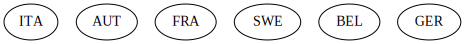

In [80]:
PROMETHEE1_ranking(alternatives, criteria)

In [14]:
def PROMETHEE2_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> list:
    ranking = sorted([(a[1][0], 
                       positive_flow(a, alternatives, criteria)-negative_flow(a, alternatives, criteria))
                       for a in alternatives.iterrows()], 
                       key = lambda x: x[1], reverse=True)
    ranking = [(name, round(score, 2)) for (name, score) in ranking]
    return ranking

In [15]:
PROMETHEE2_ranking(alternatives, criteria)

[('ITA', 3.25),
 ('AUT', 2.85),
 ('FRA', 1.9),
 ('SWE', -0.9),
 ('GER', -3.35),
 ('BEL', -3.75)]